# 6) Statistical Arbitrage — Pairs Trading

> Read me
- Run top-to-bottom. Uses simulated data only (numpy/pandas/matplotlib).
- Cells with **TODO** are what interviewers often expect you to implement.
- Keep runs fast. Vectorize when possible.
- Use clean functions with docstrings; add comments where you make assumptions.


## Setup & Data (simulated)

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

np.random.seed(21)
days = pd.date_range("2018-01-01","2020-12-31",freq="B")
pairs = [("A","B"),("C","D"),("E","F"),("G","H")]
tickers = sorted(set([x for p in pairs for x in p])) + [f"X{i}" for i in range(20)]
prices = pd.DataFrame(index=days, columns=tickers, dtype=float)
for t in tickers:
    prices[t] = 50 + np.cumsum(np.random.normal(0, 0.3, len(days)))

def make_pair():
    base = 40 + np.cumsum(np.random.normal(0,0.25,len(days)))
    eps = np.random.normal(0,0.5,len(days))
    p = base + eps; q = base*1.2 + np.random.normal(0,0.5,len(days))
    return p, q

for p,q in pairs:
    ps, qs = make_pair()
    prices[p] = ps + 10; prices[q] = qs + 10
rets = prices.pct_change().fillna(0)


In [2]:
rets

,A,B,C,D,E,F,G,H,X0,X1,...,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
2018-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-02,0.017860,0.008353,-0.012827,0.017902,-0.004915,-0.016194,-0.006355,-0.005922,0.003225,0.001488,...,-0.010883,-0.009030,0.006353,0.005759,0.011593,0.001902,-0.001821,0.000783,0.013638,0.000951
2018-01-03,-0.007487,-0.006189,0.000781,0.015452,-0.005996,0.002911,-0.003736,0.003915,-0.003381,0.000102,...,-0.007335,0.002567,-0.000993,-0.004596,0.007627,-0.002274,0.003930,-0.008379,-0.011535,0.006624
2018-01-04,0.014597,0.012933,0.017288,0.004322,-0.002545,0.001178,0.005054,-0.009128,0.010328,-0.003039,...,-0.005166,0.004997,0.006291,-0.008536,0.005698,0.006470,-0.004807,-0.009279,-0.010343,0.001587
2018-01-05,0.002800,0.022127,0.006057,-0.003497,0.000325,-0.012335,0.001835,0.008928,0.006757,0.005230,...,0.005522,-0.005405,0.005137,0.007663,0.001625,0.006056,-0.001569,-0.006038,0.005343,0.002598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,0.002518,0.004799,-0.008673,0.016926,-0.014106,0.001461,-0.033072,0.042738,-0.004877,-0.006398,...,-0.006548,0.010593,-0.005348,-0.000570,0.000093,-0.010634,-0.003695,0.010990,0.011641,0.003093
2020-12-28,-0.006207,0.029392,0.010693,-0.009869,0.036967,0.029901,0.027798,-0.010435,0.005962,0.004596,...,-0.004121,0.002494,-0.003078,-0.003603,0.006071,0.002781,0.003192,0.009601,0.001086,0.000494
2020-12-29,0.013907,-0.011128,-0.002955,0.010251,0.003572,0.000594,-0.014773,-0.006287,0.015360,-0.005712,...,-0.003022,0.009089,0.004953,0.002346,-0.009949,-0.002886,0.002543,-0.009940,-0.010831,0.003730
2020-12-30,-0.016091,0.005336,0.003755,0.017420,-0.002380,-0.005692,-0.013333,-0.036654,0.004332,-0.008223,...,0.001105,0.004690,-0.004711,0.004101,-0.008966,0.001455,-0.004209,0.005716,-0.003143,-0.002875


## TODO Checklist
1. Compute **rolling OLS** hedge ratio for each candidate pair.
2. Build residual **spread z-score** (rolling mean/std).
3. Trade rules: enter when |z|>2, exit when |z|<0.5; size by inverse spread vol.
4. Add **transaction costs** and **borrow fees**; plot cumulative.
5. Report **half-life** estimate of mean reversion for each pair.


In [65]:
window = 60

def rolling_beta(x, y, w):
    # TODO: return array of hedge ratios over time
    beta = []
    for i in range(len(x)):
        if i < w: beta.append(np.nan)
        else:
            X = np.c_[np.ones(w+1), x[i-w: i+1]]
            b = np.linalg.lstsq(X, y[i-w: i+1], rcond=None)[0]
            beta.append(b[1])
    return np.array(beta)

pnl = pd.Series(0, index=days, dtype=float)
tc = 0.0002
borrow = 0.00001

for p, q in pairs:
    x = rets[p].values
    y = rets[q].values
    b = rolling_beta(x, y, window)
    spread = y - b * x
    z = pd.Series(spread).rolling(window).apply(lambda s: (s.iloc[-1]-s.mean())/s.std(ddof=0) if s.std(ddof=0) > 0 else np.nan).values
    pos = 0
    for i, d in enumerate(days):
        b_i = b[i-1] if not np.isnan(b[i-1]) else 1.0
        pnl.iloc[i] += pos * (rets[p].iloc[i] - b_i * rets[q].iloc[i]) - borrow*abs(pos)
        if np.isnan(z[i]): continue
        if abs(z[i]) > 2 and pos == 0: # enter position
            pos = np.sign(-z[i]) # pos = inverse of z
            pnl.iloc[i] -= 2*tc
        elif abs(z[i]) < 0.5 and pos != 0:
            pos = 0
            pnl.iloc[i] -= 2*tc
        
        
# Build signals per pair and simulate strategy with costs
# TODO: implement trading loop


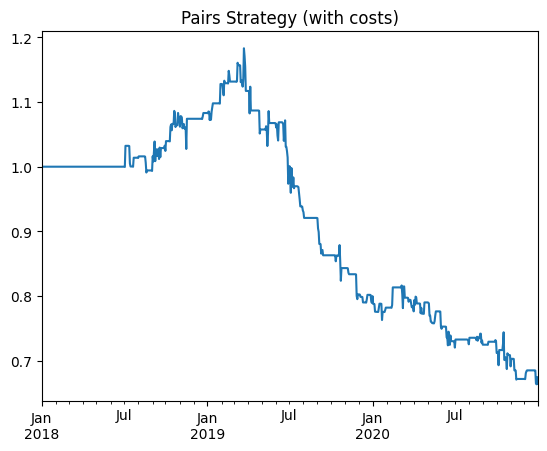

In [66]:
plt.figure(); (1+pnl).cumprod().plot(title="Pairs Strategy (with costs)"); plt.show()